1.8909684920859604
5.595010490147814
2.634076560911865
3.9452391066034522
0.12987771524367986
4.105161922580379
Correct posture!


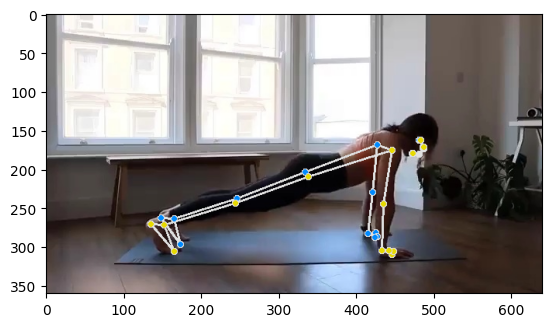

In [160]:
import numpy as np
import matplotlib.pyplot as plt
import math

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

def calculate_angle_2D(m, p1, p2, p3):
    
    point1 = (m[p1][0],m[p1][1])
    point2 = (m[p2][0],m[p2][1])
    point3 = (m[p3][0],m[p3][1])

    # Calculate the vectors from point2 to point1 and point2 to point3
    vector_21 = [point1[0] - point2[0], point1[1] - point2[1]]
    vector_23 = [point3[0] - point2[0], point3[1] - point2[1]]

    # Calculate the dot product of the vectors
    dot_product = vector_21[0]*vector_23[0] + vector_21[1]*vector_23[1]

    # Calculate the magnitudes of the vectors
    magnitude_21 = math.sqrt(vector_21[0]**2 + vector_21[1]**2)
    magnitude_23 = math.sqrt(vector_23[0]**2 + vector_23[1]**2)

    # Use the dot product to calculate the angle
    angle = math.acos(dot_product / (magnitude_21 * magnitude_23))

    # Convert the angle from radians to degrees
    angle = math.degrees(angle)

    return angle

def calculate_angle_3D(point1, point2, point3):
    # Calculate the vectors from point2 to point1 and point2 to point3
    vector_21 = [point1[0] - point2[0], point1[1] - point2[1], point1[2] - point2[2]]
    vector_23 = [point3[0] - point2[0], point3[1] - point2[1], point3[2] - point2[2]]

    # Calculate the dot product of the vectors
    dot_product = vector_21[0]*vector_23[0] + vector_21[1]*vector_23[1] + vector_21[2]*vector_23[2]

    # Calculate the magnitudes of the vectors
    magnitude_21 = math.sqrt(vector_21[0]**2 + vector_21[1]**2 + vector_21[2]**2)
    magnitude_23 = math.sqrt(vector_23[0]**2 + vector_23[1]**2 + vector_23[2]**2)

    # Use the dot product to calculate the angle
    angle = math.acos(dot_product / (magnitude_21 * magnitude_23))

    # Convert the angle from radians to degrees
    angle = math.degrees(angle)

    return angle

def angle_analysis(image, pose):

    model_path = 'pose_landmarker_heavy.task'

    BaseOptions = mp.tasks.BaseOptions
    PoseLandmarker = mp.tasks.vision.PoseLandmarker
    PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
    VisionRunningMode = mp.tasks.vision.RunningMode

    options = PoseLandmarkerOptions(
        base_options=BaseOptions(model_asset_path=model_path),
        running_mode=VisionRunningMode.IMAGE)

    with PoseLandmarker.create_from_options(options) as landmarker:
    
        # Perform pose landmarking on the provided single image.
        # The pose landmarker must be created with the image mode.
        pose_landmarker_result = landmarker.detect(image)

        pose_landmarks_list = pose_landmarker_result.pose_landmarks

        # Loop through the detected poses to visualize.
        for idx in range(len(pose_landmarks_list)):
            pose_landmarks = pose_landmarks_list[idx]

            # Draw the pose landmarks.
            pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
            pose_landmarks_proto.landmark.extend([
                landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
            ])
        
        annotated_image = draw_landmarks_on_image(image.numpy_view(), pose_landmarker_result)
        plt.imshow(annotated_image)

        m = np.zeros((33,3))

        for i in range(33):
          pose_landmark = pose_landmarks_list[0][i]
          m[i][0] = float(pose_landmark.x)
          m[i][1] = float(pose_landmark.y)
          m[i][2] = float(pose_landmark.z)

        check = 1

        if(pose==1):
          angles=np.zeros(6)
          angles[0] = calculate_angle_2D(m, 11, 23, 25)
          angles[1] = calculate_angle_2D(m, 23, 25, 27)
          angles[2] = calculate_angle_2D(m, 12, 24, 26)
          angles[3] = calculate_angle_2D(m, 24, 26, 28)
          angles[4] = calculate_angle_2D(m, 11, 13, 15)
          angles[5] = calculate_angle_2D(m, 12, 14, 16)

          for i in range(len(angles)):
            print(abs(180 - angles[i]))
            if(abs(180 - angles[i])>30):
              check = 0
              break
          
        else:
          angles=np.zeros(4)
          angles[0] = calculate_angle_2D(m, 11, 23, 25)
          angles[1] = calculate_angle_2D(m, 23, 25, 27)
          angles[2] = calculate_angle_2D(m, 12, 24, 26)
          angles[3] = calculate_angle_2D(m, 24, 26, 28)

          for i in range(len(angles)):
            print(abs(180 - angles[i]))
            if(abs(180 - angles[i])>30):
              check = 0
              break

    return check

# Load the input image from an image file.
image = mp.Image.create_from_file('..\images\correct_seq\cor_up_101_1.jpg')

check = angle_analysis(image, 1) # 0=down; 1=up
if(check == 0):
  print("Wrong posture!")
else:
  print("Correct posture!")
    
